# Task 3: Time Series Analysis

This notebook implements time series analysis following the course recommendations from:
- `8_time_series_similarity_2024.pdf`
- `5-data-understanding_ts.pdf`

## Objectives:
1. Create univariate time series for each patient (subject_id)
2. Apply preprocessing transformations (offset removal, scaling, trend removal, noise filtering)
3. Apply approximation methods (PAA) or feature extraction
4. Visualize and analyze the results

## Approach:
- Focus on ECG signals with 12 channels for each patient
- Use timestamps generated from sampling rate (500 Hz)
- Create one univariate time series per patient (using Lead II channel)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Install wfdb if not available
try:
    import wfdb
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wfdb"])
    import wfdb

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set paths - adjust if running from different directory
base_path = Path.cwd()
# If running from code directory, go up one level to find Data folder
if base_path.name == 'code':
    base_path = base_path.parent
data_path = base_path / 'Data'
code_path = base_path / 'code'
ecg_data_path = data_path / 'time-series-project2025'

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")
print(f"ECG data path: {ecg_data_path}")


Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
ECG data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/time-series-project2025


## 1. Load ECG Data from WFDB Format

Load ECG signals from WFDB format files. Each patient has a directory with .hea (header) and .dat (signal data) files.


In [2]:
def load_wfdb_ecg_data(ecg_data_path, channel_idx=1, min_samples=100):
    """
    Load ECG signals from WFDB format files.
    
    Parameters:
    -----------
    ecg_data_path : Path
        Path to the directory containing patient subdirectories
    channel_idx : int
        Index of ECG channel to extract (0-11). Default 1 (Lead II)
        Channels: 0=I, 1=II, 2=III, 3=aVR, 4=aVF, 5=aVL, 6=V1, 7=V2, 8=V3, 9=V4, 10=V5, 11=V6
    min_samples : int
        Minimum number of samples required to include a patient
    
    Returns:
    --------
    dict : Dictionary with subject_id as keys and DataFrames with 'charttime' and 'valuenum' as values
    """
    time_series_dict = {}
    ecg_data_path = Path(ecg_data_path)
    
    if not ecg_data_path.exists():
        raise FileNotFoundError(f"ECG data path not found: {ecg_data_path}")
    
    # Get all patient directories
    patient_dirs = [d for d in ecg_data_path.iterdir() if d.is_dir() and '_' in d.name]
    
    print(f"Found {len(patient_dirs)} patient directories")
    print(f"Loading ECG channel {channel_idx} (Lead II)...")
    
    channel_names = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    print(f"Extracting channel: {channel_names[channel_idx]}")
    
    loaded_count = 0
    skipped_count = 0
    
    for patient_dir in patient_dirs:
        try:
            # Extract subject_id and hadm_id from directory name (format: subject_id_hadm_id)
            parts = patient_dir.name.split('_')
            if len(parts) < 2:
                continue
            
            subject_id = int(parts[0])
            hadm_id = int(parts[1])
            
            # Find .hea and .dat files (they should have the hadm_id as name)
            hea_file = patient_dir / f"{hadm_id}.hea"
            dat_file = patient_dir / f"{hadm_id}.dat"
            
            if not hea_file.exists() or not dat_file.exists():
                # Try alternative: look for any .hea file in directory
                hea_files = list(patient_dir.glob("*.hea"))
                if not hea_files:
                    skipped_count += 1
                    continue
                hea_file = hea_files[0]
                dat_file = hea_file.with_suffix('.dat')
                if not dat_file.exists():
                    skipped_count += 1
                    continue
            
            # Read WFDB record
            record_name = str(hea_file.with_suffix(''))
            signals, fields = wfdb.rdsamp(record_name, channels=[channel_idx])
            
            # Extract signal data
            signal_data = signals[:, 0]  # Get the selected channel
            
            # Parse header to get metadata
            with open(hea_file, 'r') as f:
                header_lines = f.readlines()
            
            # Parse first line: record_name num_signals sampling_freq num_samples start_time date
            first_line = header_lines[0].strip().split()
            if len(first_line) >= 4:
                sampling_freq = float(first_line[2])
                num_samples = int(first_line[3])
                
                # Parse start time and date if available
                start_time_str = first_line[4] if len(first_line) > 4 else "00:00:00"
                date_str = first_line[5] if len(first_line) > 5 else "01/01/2000"
                
                # Parse date and time
                try:
                    # Date format: MM/DD/YYYY or DD/MM/YYYY
                    date_parts = date_str.split('/')
                    if len(date_parts) == 3:
                        # Assume MM/DD/YYYY format
                        month, day, year = int(date_parts[0]), int(date_parts[1]), int(date_parts[2])
                    else:
                        month, day, year = 1, 1, 2000
                    
                    # Time format: HH:MM:SS
                    time_parts = start_time_str.split(':')
                    if len(time_parts) >= 2:
                        hour, minute = int(time_parts[0]), int(time_parts[1])
                        second = int(time_parts[2]) if len(time_parts) > 2 else 0
                    else:
                        hour, minute, second = 0, 0, 0
                    
                    from datetime import datetime
                    start_datetime = datetime(year, month, day, hour, minute, second)
                except:
                    from datetime import datetime
                    start_datetime = datetime(2000, 1, 1, 0, 0, 0)
            else:
                sampling_freq = 500.0  # Default
                num_samples = len(signal_data)
                from datetime import datetime
                start_datetime = datetime(2000, 1, 1, 0, 0, 0)
            
            # Check if we have enough samples
            if len(signal_data) < min_samples:
                skipped_count += 1
                continue
            
            # Create timestamps based on sampling rate
            time_delta = pd.Timedelta(seconds=1/sampling_freq)
            timestamps = [start_datetime + i * time_delta for i in range(len(signal_data))]
            
            # Create DataFrame in the same format as the original notebook
            ts_df = pd.DataFrame({
                'charttime': timestamps,
                'valuenum': signal_data
            })
            
            time_series_dict[subject_id] = ts_df
            loaded_count += 1
            
            if loaded_count % 100 == 0:
                print(f"Loaded {loaded_count} patients...")
                
        except Exception as e:
            skipped_count += 1
            if skipped_count <= 5:  # Only print first few errors
                print(f"Error loading {patient_dir.name}: {str(e)}")
            continue
    
    print(f"\nSuccessfully loaded {loaded_count} patients")
    print(f"Skipped {skipped_count} patients")
    return time_series_dict

# Load ECG data
time_series_dict = load_wfdb_ecg_data(ecg_data_path, channel_idx=1, min_samples=100)

print(f"\nTotal patients with ECG time series: {len(time_series_dict):,}")
if len(time_series_dict) > 0:
    first_subject = list(time_series_dict.keys())[0]
    print(f"\nExample time series for subject {first_subject}:")
    print(time_series_dict[first_subject].head(10))
    print(f"\nTime series length: {len(time_series_dict[first_subject]):,} samples")
    print(f"Time range: {time_series_dict[first_subject]['charttime'].min()} to {time_series_dict[first_subject]['charttime'].max()}")


Found 1786 patient directories
Loading ECG channel 1 (Lead II)...
Extracting channel: II
Loaded 100 patients...
Loaded 200 patients...
Loaded 300 patients...
Loaded 400 patients...
Loaded 500 patients...
Loaded 600 patients...
Loaded 700 patients...
Loaded 800 patients...
Loaded 900 patients...
Loaded 1000 patients...
Loaded 1100 patients...
Loaded 1200 patients...
Loaded 1300 patients...
Loaded 1400 patients...
Loaded 1500 patients...
Loaded 1600 patients...
Loaded 1700 patients...

Successfully loaded 1786 patients
Skipped 0 patients

Total patients with ECG time series: 1,786

Example time series for subject 14582002:
                charttime  valuenum
0 2000-01-01 00:00:00.000  0.031383
1 2000-01-01 00:00:00.002  0.032887
2 2000-01-01 00:00:00.004  0.020256
3 2000-01-01 00:00:00.006  0.027715
4 2000-01-01 00:00:00.008  0.036823
5 2000-01-01 00:00:00.010  0.042448
6 2000-01-01 00:00:00.012  0.045848
7 2000-01-01 00:00:00.014  0.041109
8 2000-01-01 00:00:00.016  0.043849
9 2000-01-0

In [3]:
# Time series data is already loaded in time_series_dict with subject_id as keys
# Each entry contains a DataFrame with 'charttime' and 'valuenum' columns
# No merge needed - subject_id is extracted directly from directory names


## 2. Time Series Data Summary

ECG time series have been loaded. Each patient has a univariate time series from Lead II channel.


In [4]:
# ECG time series are already loaded and filtered (min_samples=100 in load function)
# Display summary statistics
print(f"ECG time series loaded: {len(time_series_dict):,} patients")
print(f"\nECG signal statistics:")

# Calculate statistics across all patients
all_lengths = [len(ts) for ts in time_series_dict.values()]
all_values = np.concatenate([ts['valuenum'].values for ts in time_series_dict.values()])

print(f"  - Number of patients: {len(time_series_dict):,}")
print(f"  - Signal length range: {min(all_lengths):,} to {max(all_lengths):,} samples")
print(f"  - Mean signal length: {np.mean(all_lengths):.1f} samples")
print(f"  - Signal value statistics:")
print(f"    Mean: {np.mean(all_values):.2f} mV")
print(f"    Std: {np.std(all_values):.2f} mV")
print(f"    Min: {np.min(all_values):.2f} mV")
print(f"    Max: {np.max(all_values):.2f} mV")


ECG time series loaded: 1,786 patients

ECG signal statistics:
  - Number of patients: 1,786
  - Signal length range: 5,000 to 5,000 samples
  - Mean signal length: 5000.0 samples
  - Signal value statistics:
    Mean: 0.01 mV
    Std: 0.16 mV
    Min: -1.53 mV
    Max: 2.27 mV


In [5]:
# ECG time series are already created for each patient
# The time_series_dict contains DataFrames with 'charttime' and 'valuenum' columns
# Each time series represents Lead II channel (channel index 1) from the 12-lead ECG

# Display sample statistics for a few patients
print("Sample ECG time series statistics for first 5 patients:")
for i, (subject_id, ts) in enumerate(list(time_series_dict.items())[:5]):
    print(f"\n  Subject {subject_id}:")
    print(f"    - Length: {len(ts):,} samples")
    print(f"    - Duration: {(ts['charttime'].max() - ts['charttime'].min()).total_seconds():.2f} seconds")
    print(f"    - Value range: {ts['valuenum'].min():.2f} to {ts['valuenum'].max():.2f} mV")
    print(f"    - Mean: {ts['valuenum'].mean():.2f} mV, Std: {ts['valuenum'].std():.2f} mV")


Sample ECG time series statistics for first 5 patients:

  Subject 14582002:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.49 to 0.86 mV
    - Mean: 0.02 mV, Std: 0.14 mV

  Subject 15789257:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.39 to 0.34 mV
    - Mean: 0.02 mV, Std: 0.10 mV

  Subject 18538902:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.17 to 0.47 mV
    - Mean: 0.03 mV, Std: 0.09 mV

  Subject 11959580:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.32 to 0.74 mV
    - Mean: 0.02 mV, Std: 0.11 mV

  Subject 15225006:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.39 to 0.35 mV
    - Mean: 0.02 mV, Std: 0.10 mV


In [6]:
# Time series are already created in time_series_dict from the load_wfdb_ecg_data function
# Each entry is a DataFrame with 'charttime' and 'valuenum' columns
# The minimum length requirement (≥100 samples) was already applied during loading

print(f"Subjects with ECG time series (≥100 samples): {len(time_series_dict):,}")
if len(time_series_dict) > 0:
    first_subject = list(time_series_dict.keys())[0]
    print(f"\nExample time series for subject {first_subject}:")
    print(time_series_dict[first_subject].head(10))
    print(f"\nTime series length: {len(time_series_dict[first_subject]):,} samples")


Subjects with ECG time series (≥100 samples): 1,786

Example time series for subject 14582002:
                charttime  valuenum
0 2000-01-01 00:00:00.000  0.031383
1 2000-01-01 00:00:00.002  0.032887
2 2000-01-01 00:00:00.004  0.020256
3 2000-01-01 00:00:00.006  0.027715
4 2000-01-01 00:00:00.008  0.036823
5 2000-01-01 00:00:00.010  0.042448
6 2000-01-01 00:00:00.012  0.045848
7 2000-01-01 00:00:00.014  0.041109
8 2000-01-01 00:00:00.016  0.043849
9 2000-01-01 00:00:00.018  0.047785

Time series length: 5,000 samples


## 3. Preprocessing Time Series

Following course recommendations, apply preprocessing transformations in order:
1. Offset Translation Removal
2. Amplitude Scaling
3. Linear Trend Removal (if needed)
4. Noise Filtering (if needed)


In [7]:
def preprocess_time_series(ts_values, apply_trend_removal=True, apply_noise_filtering=True, window_size=3):
    """
    Preprocess time series following course recommendations.
    
    Steps:
    1. Offset Translation: Q = Q - mean(Q)
    2. Amplitude Scaling: Q = (Q - mean(Q)) / std(Q)
    3. Linear Trend Removal: Fit line and subtract
    4. Noise Filtering: Moving average smoothing
    """
    values = ts_values.copy()
    original_values = values.copy()
    
    # Step 1: Offset Translation Removal
    mean_val = np.mean(values)
    values_step1 = values - mean_val
    
    # Step 2: Amplitude Scaling
    std_val = np.std(values)
    if std_val > 0:
        values_step2 = values_step1 / std_val
    else:
        values_step2 = values_step1
    
    # Step 3: Linear Trend Removal
    if apply_trend_removal and len(values) > 2:
        x = np.arange(len(values))
        slope, intercept = np.polyfit(x, values_step2, 1)
        trend = slope * x + intercept
        values_step3 = values_step2 - trend
    else:
        values_step3 = values_step2
        trend = None
    
    # Step 4: Noise Filtering (Moving Average)
    if apply_noise_filtering and len(values) >= window_size:
        values_step4 = np.convolve(values_step3, np.ones(window_size)/window_size, mode='same')
        # Handle edges
        half_window = window_size // 2
        values_step4[:half_window] = values_step3[:half_window]
        values_step4[-half_window:] = values_step3[-half_window:]
    else:
        values_step4 = values_step3
    
    return {
        'original': original_values,
        'after_offset': values_step1,
        'after_scaling': values_step2,
        'after_trend': values_step3,
        'after_noise_filter': values_step4,
        'trend': trend if apply_trend_removal else None
    }

# Test preprocessing on a sample time series
sample_subject = list(time_series_dict.keys())[0]
sample_ts = time_series_dict[sample_subject]
preprocessed = preprocess_time_series(sample_ts['valuenum'].values)

print(f"Preprocessing example for subject {sample_subject}:")
print(f"Original mean: {preprocessed['original'].mean():.2f}, std: {preprocessed['original'].std():.2f}")
print(f"After scaling mean: {preprocessed['after_scaling'].mean():.2f}, std: {preprocessed['after_scaling'].std():.2f}")


Preprocessing example for subject 14582002:
Original mean: 0.02, std: 0.14
After scaling mean: 0.00, std: 1.00


In [8]:
# Apply preprocessing to all time series
preprocessed_series = {}
for subject_id, ts in time_series_dict.items():
    preprocessed = preprocess_time_series(ts['valuenum'].values)
    preprocessed_series[subject_id] = {
        'timestamps': ts['charttime'].values,
        'original': ts['valuenum'].values,
        'preprocessed': preprocessed['after_noise_filter'],
        'all_steps': preprocessed
    }

print(f"Preprocessed {len(preprocessed_series):,} time series")


Preprocessed 1,786 time series


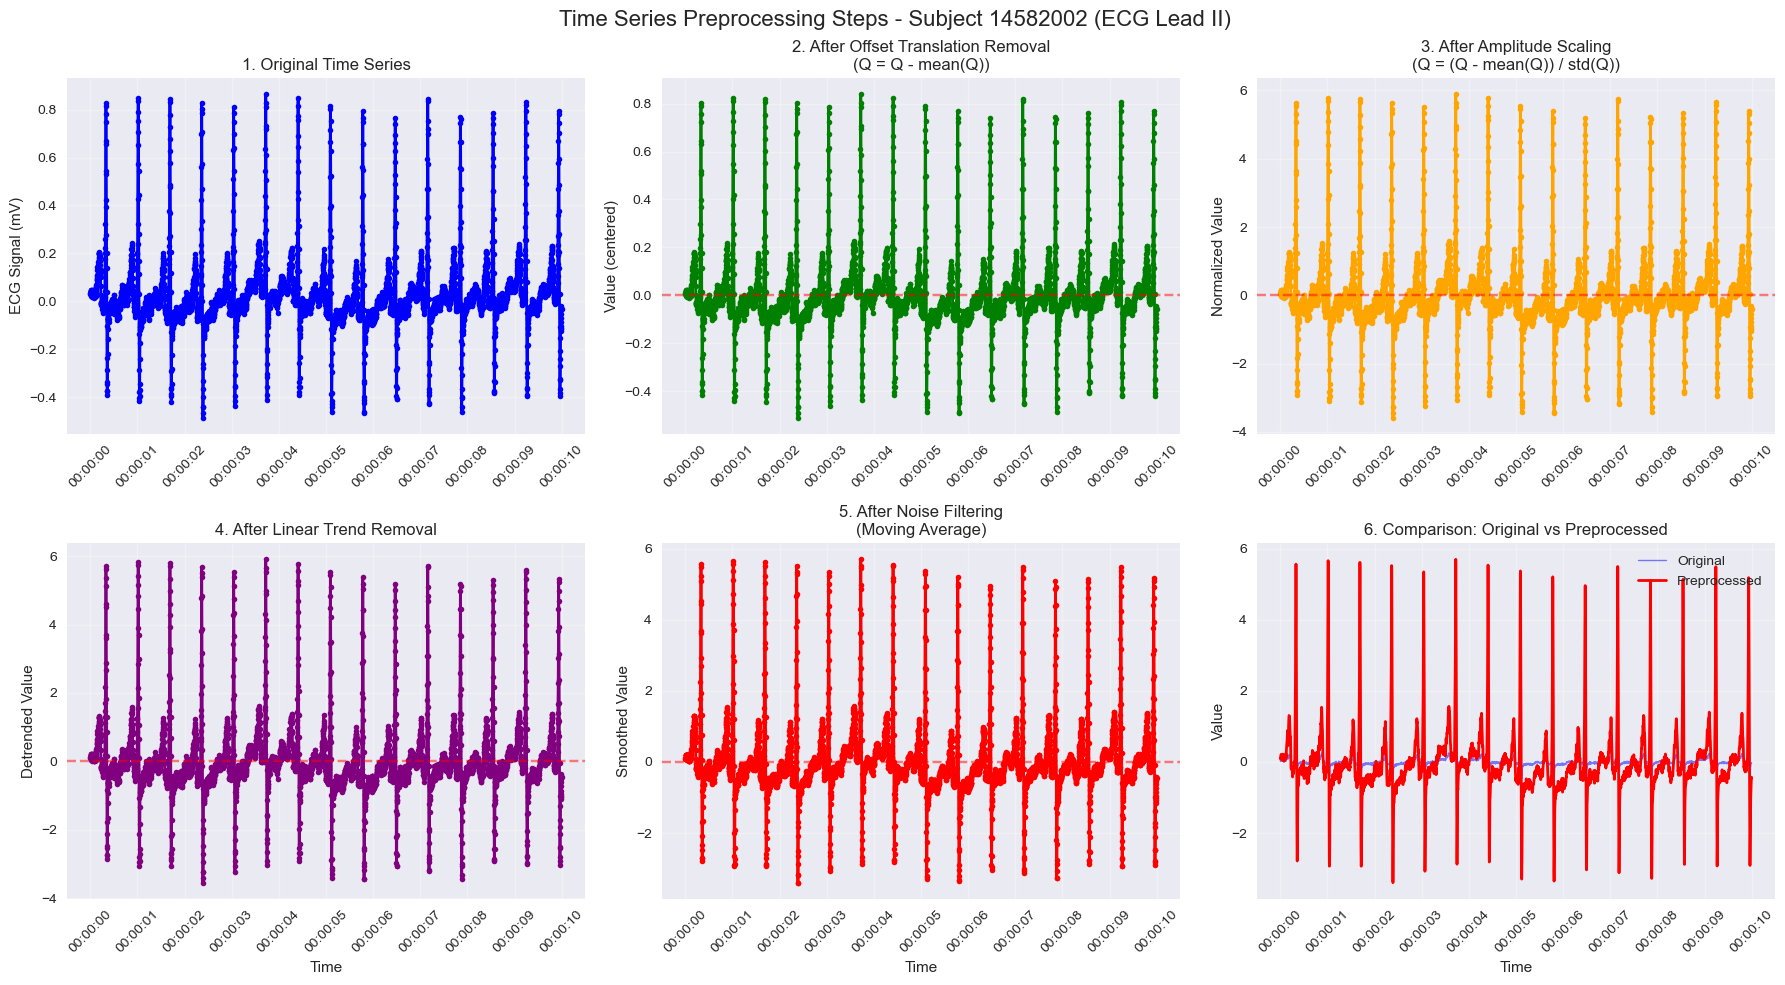

In [9]:
# Visualize preprocessing steps for a sample subject
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Time Series Preprocessing Steps - Subject {sample_subject} (ECG Lead II)', fontsize=16)

sample_data = preprocessed_series[sample_subject]
steps = sample_data['all_steps']
timestamps = sample_data['timestamps']

# Plot original
axes[0, 0].plot(timestamps, steps['original'], 'b-', linewidth=2, marker='o', markersize=4)
axes[0, 0].set_title('1. Original Time Series')
axes[0, 0].set_ylabel('ECG Signal (mV)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot after offset removal
axes[0, 1].plot(timestamps, steps['after_offset'], 'g-', linewidth=2, marker='o', markersize=4)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('2. After Offset Translation Removal\n(Q = Q - mean(Q))')
axes[0, 1].set_ylabel('Value (centered)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot after scaling
axes[0, 2].plot(timestamps, steps['after_scaling'], 'orange', linewidth=2, marker='o', markersize=4)
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 2].set_title('3. After Amplitude Scaling\n(Q = (Q - mean(Q)) / std(Q))')
axes[0, 2].set_ylabel('Normalized Value')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot after trend removal
axes[1, 0].plot(timestamps, steps['after_trend'], 'purple', linewidth=2, marker='o', markersize=4)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('4. After Linear Trend Removal')
axes[1, 0].set_ylabel('Detrended Value')
axes[1, 0].set_xlabel('Time')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot after noise filtering
axes[1, 1].plot(timestamps, steps['after_noise_filter'], 'red', linewidth=2, marker='o', markersize=4)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('5. After Noise Filtering\n(Moving Average)')
axes[1, 1].set_ylabel('Smoothed Value')
axes[1, 1].set_xlabel('Time')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot comparison: original vs final
axes[1, 2].plot(timestamps, steps['original'], 'b-', linewidth=1, alpha=0.5, label='Original')
axes[1, 2].plot(timestamps, steps['after_noise_filter'], 'r-', linewidth=2, label='Preprocessed')
axes[1, 2].set_title('6. Comparison: Original vs Preprocessed')
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_xlabel('Time')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(code_path / 'time_series_preprocessing_steps.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
def paa_transform(ts_values, num_segments):
    """
    Piecewise Aggregate Approximation (PAA).
    
    Divides time series into w equal-sized segments and replaces
    values in each segment with their average.
    
    Parameters:
    - ts_values: array of time series values
    - num_segments: number of segments (w)
    
    Returns:
    - paa_values: approximated time series
    - segment_indices: indices where segments start
    """
    n = len(ts_values)
    if num_segments >= n:
        return ts_values, np.arange(n)
    
    segment_size = n / num_segments
    paa_values = []
    segment_indices = [0]
    
    for i in range(num_segments):
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        if end_idx > n:
            end_idx = n
        
        # Average of segment
        segment_mean = np.mean(ts_values[start_idx:end_idx])
        paa_values.append(segment_mean)
        
        if i < num_segments - 1:
            segment_indices.append(end_idx)
    
    return np.array(paa_values), np.array(segment_indices)

# Test PAA on sample time series
sample_values = preprocessed_series[sample_subject]['preprocessed']
paa_result, segment_idx = paa_transform(sample_values, num_segments=5)

print(f"Original length: {len(sample_values)}")
print(f"PAA length: {len(paa_result)}")
print(f"PAA values: {paa_result}")
print(f"Compression ratio: {len(sample_values) / len(paa_result):.2f}x")


Original length: 5000
PAA length: 5
PAA values: [ 0.00148133  0.05876458 -0.08384949 -0.05194687  0.07552085]
Compression ratio: 1000.00x


In [11]:
# Apply PAA to all preprocessed time series
# Use adaptive number of segments based on series length
paa_results = {}
for subject_id, data in preprocessed_series.items():
    ts_values = data['preprocessed']
    # Use approximately 1/3 of original length, but at least 3 and at most 10
    num_segments = max(3, min(10, len(ts_values) // 3))
    paa_values, segment_idx = paa_transform(ts_values, num_segments)
    paa_results[subject_id] = {
        'paa_values': paa_values,
        'num_segments': num_segments,
        'original_length': len(ts_values)
    }

print(f"Applied PAA to {len(paa_results):,} time series")
print(f"\nExample PAA result for subject {sample_subject}:")
print(f"Original length: {paa_results[sample_subject]['original_length']}")
print(f"PAA segments: {paa_results[sample_subject]['num_segments']}")
print(f"PAA values: {paa_results[sample_subject]['paa_values']}")


Applied PAA to 1,786 time series

Example PAA result for subject 14582002:
Original length: 5000
PAA segments: 10
PAA values: [ 0.13319263 -0.13022997 -0.10128043  0.21880959  0.15543111 -0.32313008
 -0.0943855  -0.00950823 -0.00375581  0.15479751]


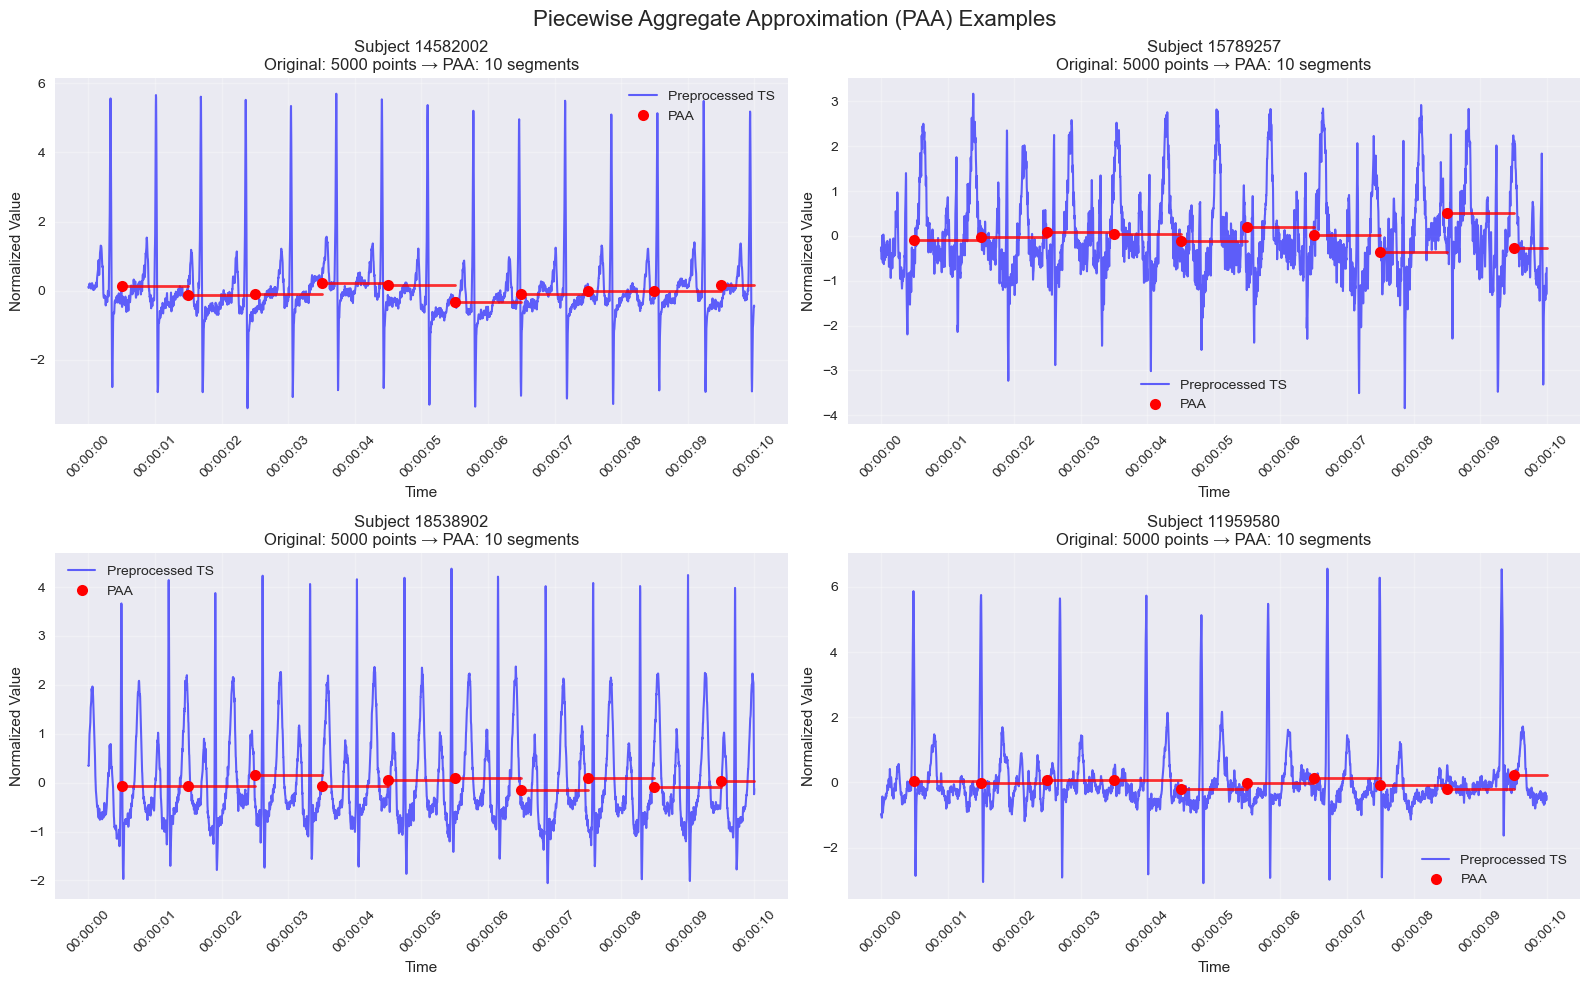

In [12]:
# Visualize PAA approximation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Piecewise Aggregate Approximation (PAA) Examples', fontsize=16)

# Select a few subjects to visualize
subjects_to_plot = list(preprocessed_series.keys())[:4]

for idx, subject_id in enumerate(subjects_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    data = preprocessed_series[subject_id]
    timestamps = data['timestamps']
    original = data['preprocessed']
    
    # Get PAA result
    paa_vals = paa_results[subject_id]['paa_values']
    num_segments = paa_results[subject_id]['num_segments']
    
    # Reconstruct PAA time series for visualization
    segment_size = len(original) / num_segments
    paa_timestamps = []
    paa_reconstructed = []
    
    for i in range(num_segments):
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        if end_idx > len(original):
            end_idx = len(original)
        
        # Use midpoint timestamp of segment
        mid_idx = (start_idx + end_idx) // 2
        paa_timestamps.append(timestamps[mid_idx])
        paa_reconstructed.append(paa_vals[i])
    
    # Plot original
    ax.plot(timestamps, original, 'b-', linewidth=1.5, alpha=0.6, label='Preprocessed TS')
    
    # Plot PAA approximation (step function)
    paa_timestamps = np.array(paa_timestamps)
    paa_reconstructed = np.array(paa_reconstructed)
    
    # Create step plot for PAA
    for i in range(len(paa_reconstructed) - 1):
        start_time = paa_timestamps[i]
        end_time = paa_timestamps[i + 1]
        ax.plot([start_time, end_time], [paa_reconstructed[i], paa_reconstructed[i]], 
                'r-', linewidth=2, alpha=0.8)
        if i == 0:
            ax.plot([start_time], [paa_reconstructed[i]], 'ro', markersize=8, label='PAA')
        else:
            ax.plot([start_time], [paa_reconstructed[i]], 'ro', markersize=8)
    
    # Plot last segment
    if len(paa_reconstructed) > 0:
        last_time = timestamps[-1]
        ax.plot([paa_timestamps[-1], last_time], 
                [paa_reconstructed[-1], paa_reconstructed[-1]], 
                'r-', linewidth=2, alpha=0.8)
        ax.plot([paa_timestamps[-1]], [paa_reconstructed[-1]], 'ro', markersize=8)
    
    ax.set_title(f'Subject {subject_id}\nOriginal: {len(original)} points → PAA: {num_segments} segments')
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(code_path / 'time_series_paa_approximation.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Feature Extraction

Extract statistical features from the preprocessed time series as an alternative/complementary approach.


In [13]:
def extract_time_series_features(ts_values):
    """
    Extract statistical features from time series.
    
    Features:
    - Mean, Variance, Std
    - Min, Max, Range
    - Trend (slope of linear fit)
    - Auto-covariance (lag-1)
    - Rolling statistics (if applicable)
    """
    features = {}
    
    # Basic statistics
    features['mean'] = np.mean(ts_values)
    features['variance'] = np.var(ts_values)
    features['std'] = np.std(ts_values)
    features['min'] = np.min(ts_values)
    features['max'] = np.max(ts_values)
    features['range'] = features['max'] - features['min']
    features['median'] = np.median(ts_values)
    
    # Trend (slope of linear fit)
    if len(ts_values) > 1:
        x = np.arange(len(ts_values))
        slope, intercept = np.polyfit(x, ts_values, 1)
        features['trend_slope'] = slope
        features['trend_intercept'] = intercept
    else:
        features['trend_slope'] = 0
        features['trend_intercept'] = ts_values[0] if len(ts_values) > 0 else 0
    
    # Auto-covariance (lag-1)
    if len(ts_values) > 1:
        features['autocov_lag1'] = np.cov(ts_values[:-1], ts_values[1:])[0, 1]
    else:
        features['autocov_lag1'] = 0
    
    # Percentiles
    features['q25'] = np.percentile(ts_values, 25)
    features['q75'] = np.percentile(ts_values, 75)
    features['iqr'] = features['q75'] - features['q25']
    
    return features

# Extract features from all preprocessed time series
ts_features = {}
for subject_id, data in preprocessed_series.items():
    ts_values = data['preprocessed']
    features = extract_time_series_features(ts_values)
    ts_features[subject_id] = features

# Convert to DataFrame for easier analysis
features_df = pd.DataFrame.from_dict(ts_features, orient='index')
features_df.index.name = 'subject_id'

print(f"Extracted features from {len(ts_features):,} time series")
print(f"\nFeature statistics:")
print(features_df.describe())


Extracted features from 1,786 time series

Feature statistics:
              mean     variance          std          min          max  \
count  1786.000000  1786.000000  1786.000000  1786.000000  1786.000000   
mean     -0.000005     0.962072     0.980615    -2.594143     5.411610   
std       0.000020     0.040614     0.021624     1.090645     2.004787   
min      -0.000112     0.765473     0.874913    -5.118884     1.711337   
25%      -0.000013     0.964170     0.981922    -3.396348     4.369692   
50%      -0.000002     0.973554     0.986689    -2.298933     5.431955   
75%       0.000007     0.979627     0.989761    -1.877506     6.509404   
max       0.000049     0.990390     0.995183    -0.665121    11.424836   

             range       median   trend_slope  trend_intercept  autocov_lag1  \
count  1786.000000  1786.000000  1.786000e+03      1786.000000   1786.000000   
mean      8.005753    -0.134745  2.208462e-09        -0.000010      0.947091   
std       1.745263     0.15057

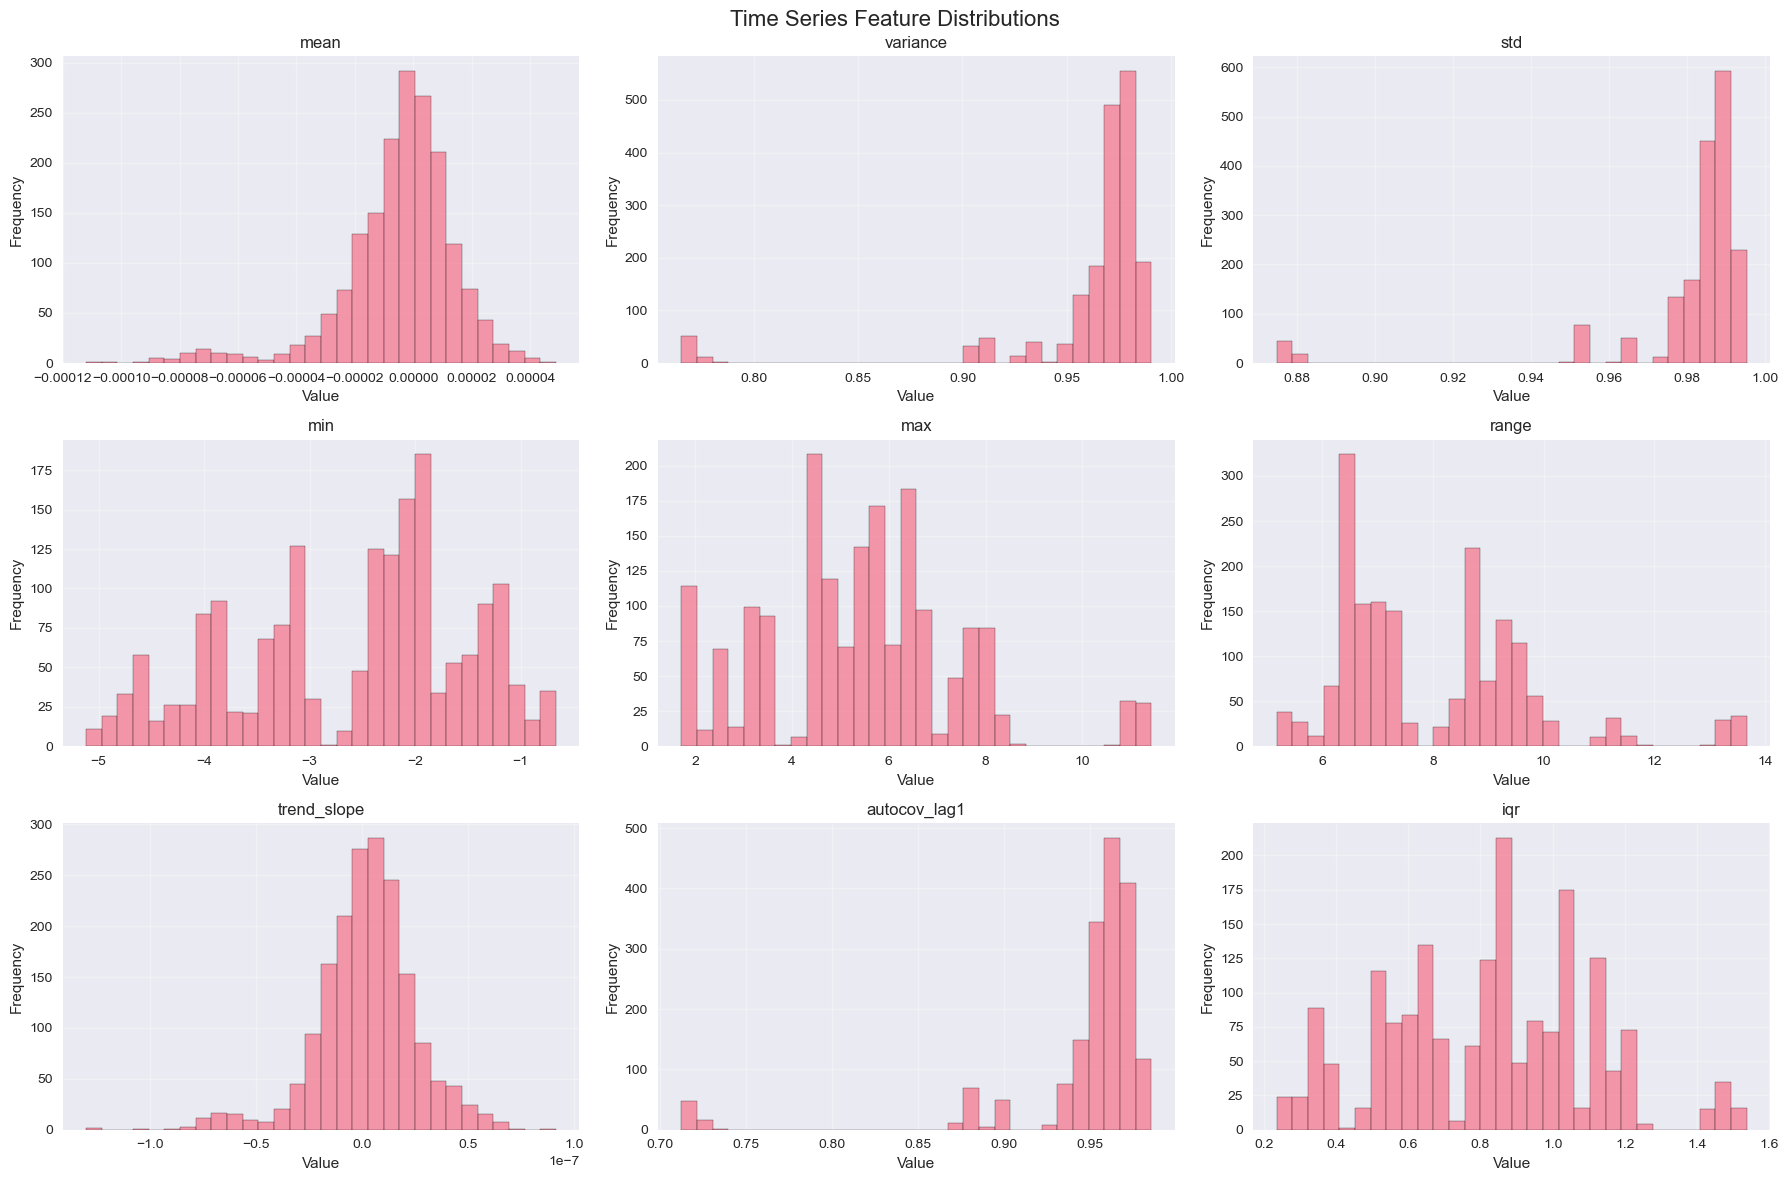

In [14]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Time Series Feature Distributions', fontsize=16)

feature_cols = ['mean', 'variance', 'std', 'min', 'max', 'range', 'trend_slope', 'autocov_lag1', 'iqr']
for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(features_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(code_path / 'time_series_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Summary statistics
print("="*60)
print("TIME SERIES ANALYSIS SUMMARY")
print("="*60)
print(f"\n1. Data Overview:")
print(f"   - ECG signal analyzed: Lead II channel")
total_samples = sum([len(ts) for ts in time_series_dict.values()])
print(f"   - Total signal samples: {total_samples:,}")
print(f"   - Unique subjects: {len(time_series_dict):,}")
print(f"   - Subjects with time series (≥100 samples): {len(time_series_dict):,}")

print(f"\n2. Preprocessing:")
print(f"   - Applied offset translation removal")
print(f"   - Applied amplitude scaling (z-normalization)")
print(f"   - Applied linear trend removal")
print(f"   - Applied noise filtering (moving average)")

print(f"\n3. Approximation (PAA):")
avg_compression = np.mean([r['original_length'] / r['num_segments'] 
                           for r in paa_results.values()])
print(f"   - Average compression ratio: {avg_compression:.2f}x")
print(f"   - Average segments per series: {np.mean([r['num_segments'] for r in paa_results.values()]):.1f}")

print(f"\n4. Feature Extraction:")
print(f"   - Number of features extracted: {len(features_df.columns)}")
print(f"   - Features: {', '.join(features_df.columns.tolist())}")

print(f"\n5. Time Series Length Statistics:")
ts_lengths = [len(data['preprocessed']) for data in preprocessed_series.values()]
print(f"   - Mean length: {np.mean(ts_lengths):.1f} samples")
print(f"   - Median length: {np.median(ts_lengths):.1f} samples")
print(f"   - Min length: {np.min(ts_lengths)} samples")
print(f"   - Max length: {np.max(ts_lengths)} samples")

print("\n" + "="*60)


TIME SERIES ANALYSIS SUMMARY

1. Data Overview:
   - ECG signal analyzed: Lead II channel
   - Total signal samples: 8,930,000
   - Unique subjects: 1,786
   - Subjects with time series (≥100 samples): 1,786

2. Preprocessing:
   - Applied offset translation removal
   - Applied amplitude scaling (z-normalization)
   - Applied linear trend removal
   - Applied noise filtering (moving average)

3. Approximation (PAA):
   - Average compression ratio: 500.00x
   - Average segments per series: 10.0

4. Feature Extraction:
   - Number of features extracted: 13
   - Features: mean, variance, std, min, max, range, median, trend_slope, trend_intercept, autocov_lag1, q25, q75, iqr

5. Time Series Length Statistics:
   - Mean length: 5000.0 samples
   - Median length: 5000.0 samples
   - Min length: 5000 samples
   - Max length: 5000 samples



In [17]:
# Save results
output_path = data_path / '3.1_time_series_features.csv'
features_df.to_csv(output_path)
print(f"Saved time series features to: {output_path}")

# Save PAA results summary
paa_summary = pd.DataFrame({
    'subject_id': list(paa_results.keys()),
    'original_length': [r['original_length'] for r in paa_results.values()],
    'paa_segments': [r['num_segments'] for r in paa_results.values()],
    'compression_ratio': [r['original_length'] / r['num_segments'] for r in paa_results.values()]
})
paa_output_path = data_path / '3.1_time_series_paa_summary.csv'
paa_summary.to_csv(paa_output_path, index=False)
print(f"Saved PAA summary to: {paa_output_path}")

print("\n✓ Time series analysis complete!")


Saved time series features to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_features.csv
Saved PAA summary to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_paa_summary.csv

✓ Time series analysis complete!
